In [68]:
from dataloader import load_balanced_binary_dataset
import backend.src.utils.utils as utils

In [69]:
data = load_balanced_binary_dataset()
data = utils.clean_text(data, "text")

In [70]:
data

,sent_id,text,label
3632,303311-03-02,honningbarna kjapt snakkis stakk urørt seieren,1
346,305017-11-02,sjelden lest elegant skildring bryllup biograf...,1
1659,702913-05-01,manusforfatter thomas moldestad fått sving kom...,1
237,400565-26-01,bjølsen valsemølle finstemt gruppe gir vitalt ...,1
749,200323-02-01,testet populære middagsabonnementet vestlandet,1
...,...,...,...
829,003283-14-02,shaiman greier heller låtene derfor litt anony...,0
1171,107878-12-02,vraket midtbanemotoren satt stjernespissen tra...,0
2680,101562-07-04,tenker slutten nærmer time enda eksplosjoner e...,0
1946,100122-09-02,gi nytt,0


<AxesSubplot:>

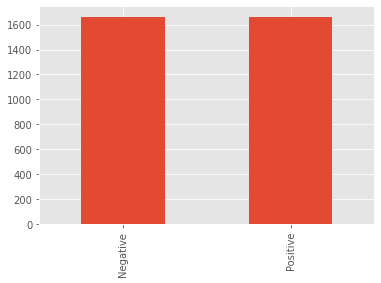

In [71]:
data["label"].replace({0: "Negative", 1: "Positive"}).value_counts().sort_index().plot.bar()

<AxesSubplot:ylabel='Frequency'>

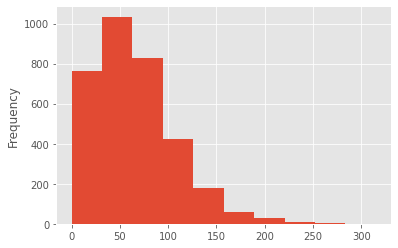

In [72]:
data["text"].str.len().plot.hist()

In [73]:
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras_preprocessing.sequence import pad_sequences

X_train, X_test, y_train, y_test = train_test_split(data["text"], data["label"], test_size=0.1, random_state=42, shuffle=True)

tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [74]:
from random import randint

random_idx = randint(0, len(X_train))
review_label_mapping = {0: "Negative", 1: "Positive"}
review_label = review_label_mapping[int(y_train.iloc[random_idx])]

print(f"Review {random_idx} contains {len(X_train[random_idx])} words and is {review_label}")
print("Review content:", end="\n\n")
print(" ".join(tokenizer.index_word[idx] for idx in X_train[random_idx]))

Review 240 contains 11 words and is Positive
Review content:

alt alt severdig film stavanger attpåtil lekker låt sunget eili harboe


In [75]:
from collections import Counter

word_counter = Counter()
for review in X_train:
    for word in review:
        word_counter[tokenizer.index_word[word]] += 1

In [76]:
word_counter.most_common(10)

[('litt', 155),
 ('gjør', 95),
 ('får', 93),
 ('godt', 92),
 ('helt', 86),
 ('filmen', 83),
 ('to', 80),
 ('the', 75),
 ('nok', 75),
 ('hele', 70)]

In [77]:
maxlen = 100

X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

In [78]:
import numpy as np

y_train = np.array(y_train)
y_test = np.array(y_test)

In [79]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (2993, 100)
X_test shape: (333, 100)


In [80]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding

model = Sequential()
model.add(Embedding(input_dim=20000, output_dim=128, trainable=True))
model.add(LSTM(units=128, dropout=0.4, return_sequences=True))
model.add(LSTM(units=128, dropout=0.4))
model.add(Dense(units=1, activation='sigmoid'))

In [81]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 128)         2560000   
                                                                 
 lstm_3 (LSTM)               (None, None, 128)         131584    
                                                                 
 lstm_4 (LSTM)               (None, 128)               131584    
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,823,297
Trainable params: 2,823,297
Non-trainable params: 0
_________________________________________________________________


In [82]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_accuracy", mode="max", patience=3)

epochs = 20
batch_size = 16
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1,
                    callbacks=[early_stop])

Epoch 1/20
150/150 [==============================] - 36s 206ms/step - loss: 0.6919 - accuracy: 0.5251 - val_loss: 0.6879 - val_accuracy: 0.5492
Epoch 2/20
150/150 [==============================] - 27s 179ms/step - loss: 0.4812 - accuracy: 0.7820 - val_loss: 0.7033 - val_accuracy: 0.6694
Epoch 3/20
150/150 [==============================] - 30s 200ms/step - loss: 0.1373 - accuracy: 0.9453 - val_loss: 1.0203 - val_accuracy: 0.6628
Epoch 4/20
150/150 [==============================] - 26s 175ms/step - loss: 0.0460 - accuracy: 0.9825 - val_loss: 1.2915 - val_accuracy: 0.6461
Epoch 5/20
150/150 [==============================] - 28s 185ms/step - loss: 0.0248 - accuracy: 0.9921 - val_loss: 1.2472 - val_accuracy: 0.6294


In [83]:
from datetime import datetime

model.save(f"models/SA-LSTM-BINARY-BALANCED-{datetime.now().strftime('%Y%m%d%H%M%S')}.h5")

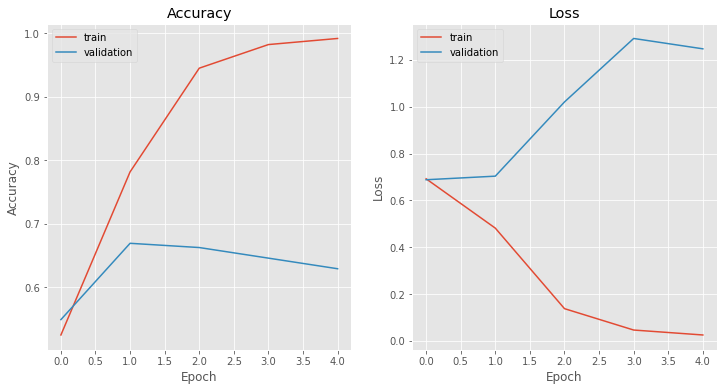

In [84]:
from backend.src.utils.utils import plot_history

plot_history(history)

In [85]:
# Evaluation
val_loss, val_acc = model.evaluate(X_test, y_test)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

11/11 [==============================] - 1s 72ms/step - loss: 1.2280 - accuracy: 0.6396
Validation loss: 1.2279958724975586
Validation accuracy: 0.6396396160125732
